In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [9]:
from torchmetrics import MeanAbsolutePercentageError as MAPE

In [15]:
df = pd.read_csv("AirfoilSelfNoise.csv")
df.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [16]:
#Negative values check
df.lt(0).sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
SSPL          0
dtype: int64

In [17]:
#zeros check
(df == 0).sum()
#alpha being zero as it serves as angle of attack. 0 would equate to parallel flow

f               0
alpha         329
c               0
U_infinity      0
delta           0
SSPL            0
dtype: int64

In [18]:
#NAs check
df.isna().sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
SSPL          0
dtype: int64

array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'U_infinity'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'SSPL'}>]], dtype=object)

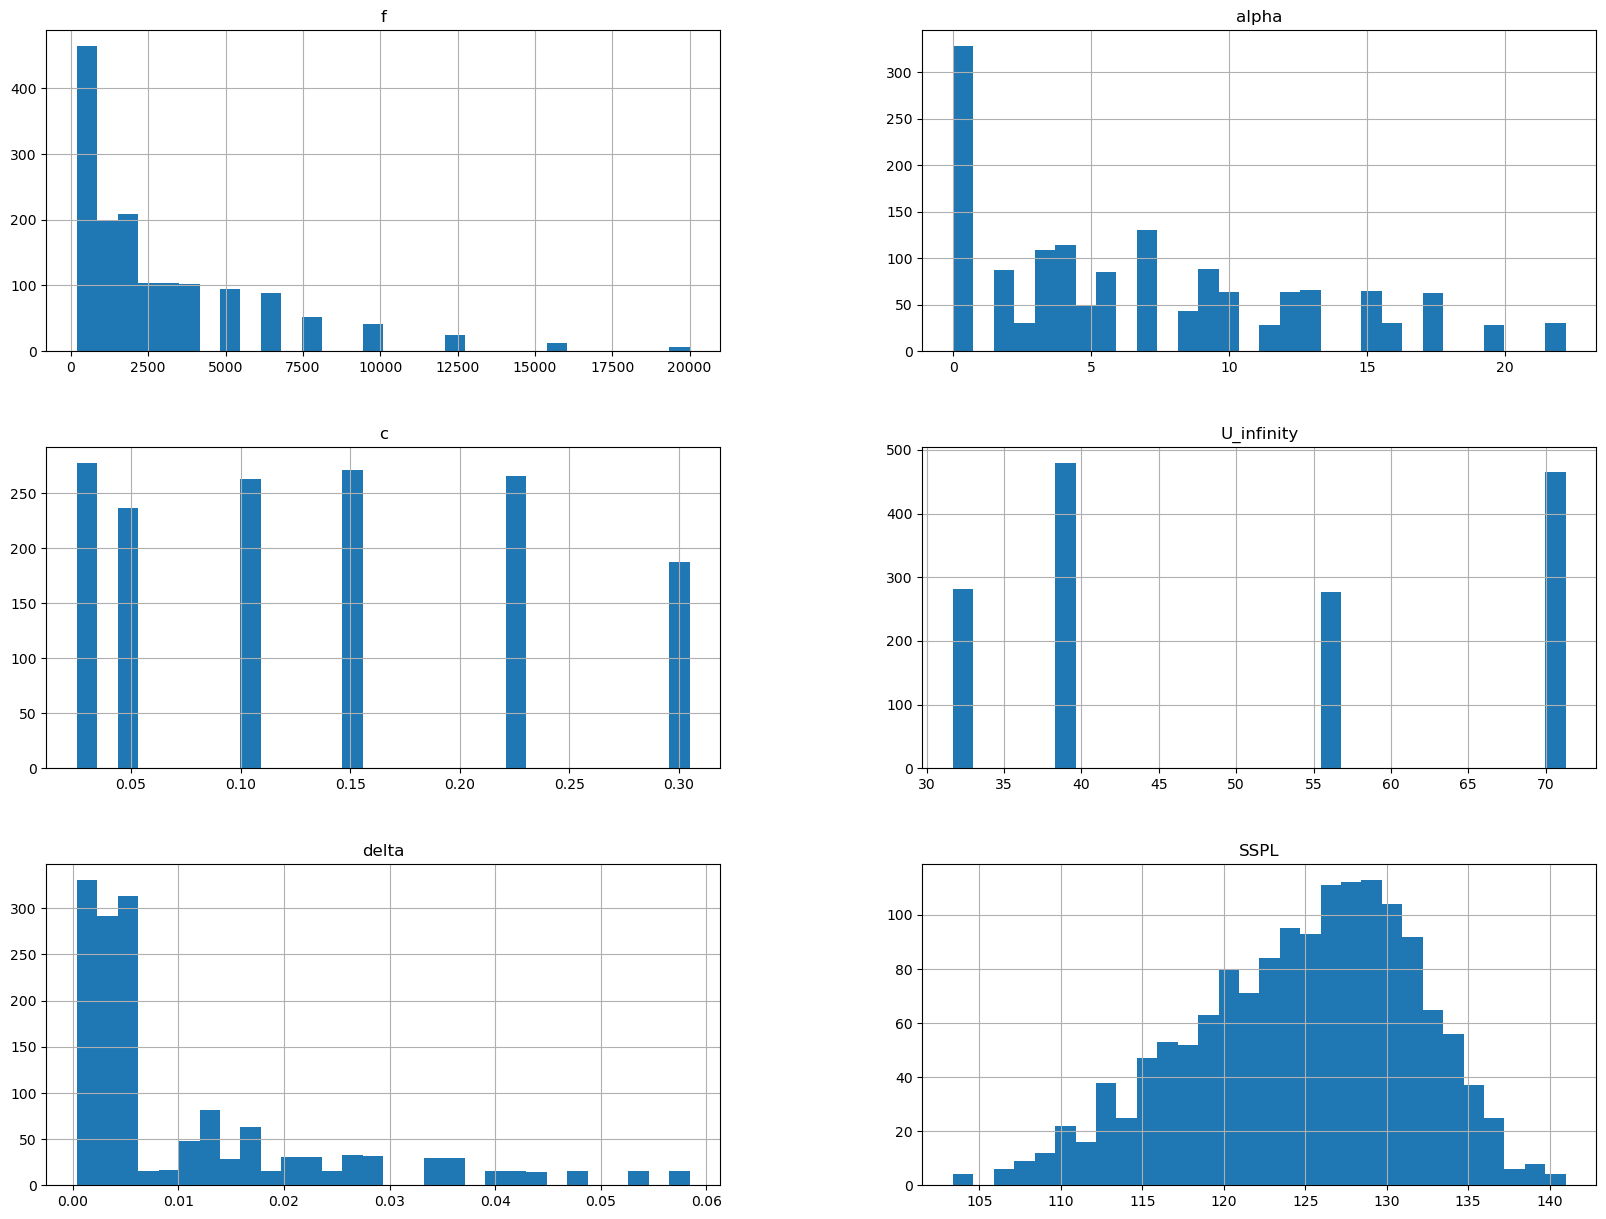

In [19]:
df.hist(bins=30, figsize=(20, 15))

In [2]:

#data = fetch_california_housing() #change input data 
#X, y = data.data, data.target
#X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [21]:
#scaling
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_all = scaler.transform(X)

In [22]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
x_all = torch.tensor(X_all,dtype=torch.float32)

c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\vborozniak\anaconda3\envs\gpu3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [5]:
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [10]:
# loss function and optimizer
loss_fn = MAPE()  # mean percentage error
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
n_epochs = 50   # number of epochs to run. Incorporate early stoppping!
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [14]:
best_mape = np.inf   # init to infinity
best_weights = None
history = []


In [18]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:  #try executing in different editor
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()  #need to add training loss as well to plot both histories
    y_pred = model(X_test) 
    mape = loss_fn(y_pred, y_test)
    mape = float(mape)
    history.append(mape)
    if mape < best_mape:
        best_mape = mape
        best_weights = copy.deepcopy(model.state_dict())

MAPE: 0.19


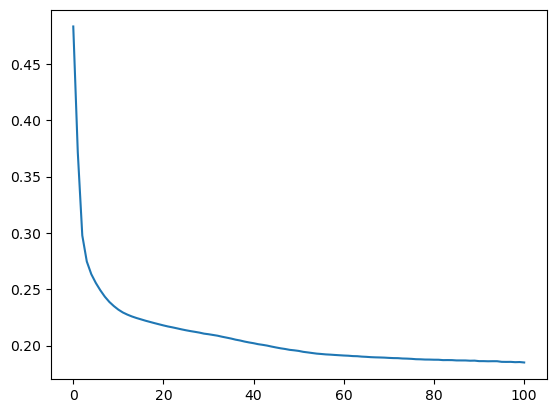

In [19]:
model.load_state_dict(best_weights)
print("MAPE: %.2f" % best_mape)
#print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [23]:
all_data_pred = model(x_all)

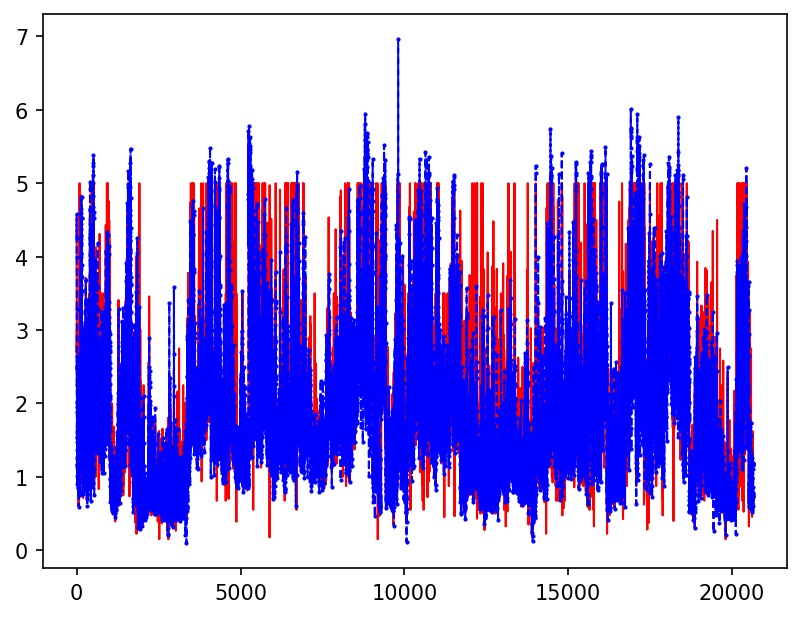

In [27]:
plt.figure(dpi=150)
plt.plot(y, color = 'red', label = 'Real',linewidth = 1)
plt.plot(all_data_pred.detach().numpy(), color = 'blue', label = 'Predicted',linestyle = 'dashed',marker = 'o',markersize = 1,linewidth = 1)